# _songlyrics.com scraping_
<hr style="height:2px;border-width:0;color:black;background-color:black">

#### Intro
This part of the project is the data scraping from the site songlyrics.com, we have 3 sections.

The main section:
The data scraping is implemented by using the requests library and beautiful soup library.
The data is stored in a temporary dataframe and uploaded to a CSV file.

The visualization section:
Show with bar plot and box plot the scraped data.

The debug section:
General place to check failed urls responses or failed data scrap and more.

### Imports cell

In [ ]:
# Time stamps and os tools imports
import time 
from time import sleep
from datetime import datetime
import os 

# Alphabetlist import
import string as string

# Beautifulsoup imports
import bs4
from bs4 import BeautifulSoup as bs

# Data frames and math imports
import pandas as pd
import scipy as sc
import numpy as np
from numpy import random

# Web page HTTP requets imports
import requests
import traceback

# Google language detectiion import
from langdetect import detect

#randomize int import
from random import randint

# Progress bar
import tqdm

# Plot import for visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Request sleep method, randomize sleep to avoid detection

In [ ]:
def request_sleep(min_rand_val, max_rand_val):
    sleept_time = random.uniform(min_rand_val, max_rand_val)
#     print(f"   Start sleeping for: {sleept_time:.2f} seconds until next request...")
    sleep(sleept_time)
#     print("   sleeping is over!\n")

### Global veriables for requests and urls

In [ ]:
start_url = "http://www.songlyrics.com/"
headers = {
    'Connection': 'keep-alive',
    'Cache-Control': 'max-age=0',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'he-IL,he;q=0.9,en-US;q=0.8,en;q=0.7',
}

### Get main artist pages by alphabetical order

In [ ]:
def get_alphabet_urls(start_url):
    main_menu_urls = []
    
    alphabet_string = string.ascii_lowercase
    alphabet_list = list(alphabet_string)
    
    for alphabet_item in alphabet_list:
        main_menu_urls.append(start_url + alphabet_item + "/")
        
    main_menu_urls.append(start_url + "0/") # the '#' item in the menu
    
    return main_menu_urls

#### Check get_alphabet_urls method

In [ ]:
# main_alpha = get_alphabet_urls(start_url)
# print(len(main_alpha[10:]))
# print(main_alpha[10:])

### Request method for each given url.

#### In case of failure print the response code and move on or retry connection, depends on the problem.

In [ ]:
def get_request_response(url, headers):
    start = time.time()
    i=0
#     print(f"   ============   Start request for url: {url}   ============   ")
    while(i <= 3):
        try:
            response = requests.get(url, headers=headers, timeout=3)
            end = time.time()
            elapsed_time = end - start
            if(response.status_code == 200):
#                 print(f"   Request get is successful! with response code: {response.status_code} after {elapsed_time:.4f} seconds")
                return response
            else:
                print(f"   failed with response code: {response.status_code}  after {elapsed_time} seconds\n   , {url} ")
                return None
        except:
            request_sleep(3,5)
            print("   Retrying again..")
            i+=1
            if(i == 3):
                print("!!!  Timed out  !!!")
                return None

#### Check general connectivity with the get_request_response method

In [ ]:
# url1="https://httpbin.org/ip"
# url2="https://httpbin.org/headers"

# request_sleep(3,5)
# response_proxies = get_request_response(url1, headers)

# request_sleep(3,5)
# response_headers = get_request_response(url2, headers)

# print(response_proxies.json())
# print()
# print(response_headers.json())

### songlyrics.com crawling flow:
<hr style="height:1px;border-width:0;color:black;background-color:black">

1. Crawl main artist pages by alphabetical order
    - In each page find the artists urls.
    
    - Append to the list if the artist has more than 20 songs, bigger probability to contain genre.


2. Append from each artist url all the song urls into a list.
    - In case of no genre, no need to append the song urls to a list, move to next artist.


3. Crawl each song url, append into a temporary dataframe the song title and lyrics and the relevant genre.
    - For the title: 
                     If title is found, clean it from any irrelevant text (for example the word "lyrics") and append.
                     else print no title found and leave the page.
    - For the lyrics: 
                     If the lyrics are found append to the dataframe.
                     else print no lyrics found and leave the page.
    - Language of the lyrics: we only want to append lyrics that are in english
                     If the song is in english we append
                     else we print that the song is not in english and not relevant and leave the page.
                     
                     
4. Use the temporary dataframe to append into a CSV file.
    - Check if the file already exists, if not create a new one and append the data into it.
    - If the file already exists, read the csv file to check for duplicates and append the new lyrics.

In [ ]:
def append_lyrics_to_csv(response, genre_text):
    song_title = ""
    song_lyrics = ""
    song_artist = ""
    df = pd.DataFrame([], columns=['title', 'lyrics', 'genre'])
    
    soup_page_main = bs(response.content, "html.parser")
    
    # Song artist name
    artist_names = soup_page_main.select('div.pagetitle > p > a')[0]
    for artist_name in artist_names:
        song_artist = artist_name

    # Song title
    titles = soup_page_main.select('div.pagetitle > h1')
    if(len(titles) == 0):
        print(" ! There is no title !")
        return
    else:
        for title in titles:
            song_title = title.text
            if song_title.endswith(' Lyrics'):
                song_title = song_title[:-7]
            if (song_title.startswith(f'{song_artist} - ')):
                song_title = song_title[(len(song_artist) + 3):]
#             print(song_title)
#             print()


    #Song lyrics
    lyrics = soup_page_main.select('p.iComment-text.songLyricsV14')
    if (len(lyrics) == 0 or "We do not have the lyrics for" in lyrics[0].text):
        print(" ! There are no lyrics !")
        return
    else:
        for lyric in lyrics:
            song_lyrics = lyric.text
#             print(song_lyrics)
    
    # Checking is song is in english, not intested in non english songs
    if(detect(song_lyrics) == 'en'):
        df = df.append({'title': song_title, 'lyrics': song_lyrics, 'genre': genre_text}, ignore_index=True)
        if not os.path.isfile('lyrics.csv'):
            df.to_csv('lyrics.csv', index=False)
        else: # else it exists so append without writing the header
            pd.read_csv('lyrics.csv').append(df).drop_duplicates().to_csv('lyrics.csv', index=False)
        print(f"   lyrics for song \"{song_title}\" has been appended")
    else:
        print(" ! Text is not in english not appending !")
        return

In [ ]:
def crawl_song_urls(song_urls, song_genre):
    for uidx, url in enumerate(song_urls):
        if(len(song_urls) == 1):
            request_sleep(2,3)
        lyrics_pages_response = get_request_response(url, headers)
        if (lyrics_pages_response is not None):
            #appending the lyrics from the url given
            append_lyrics_to_csv(lyrics_pages_response, song_genre)
        else:
            print("!! Song url response is none moving on.. !!")

        if(uidx == (len(song_urls) - 1)):
            print(f"   *########* Last artist: {url} , at index: {uidx} *########*\n   $###$ Finished with all songs $###$")
            break
        else: # Moving to next song 
            #print(f"   *########* Complete for song at url: {url}\n   Moving to next song url *########*\n")
            request_sleep(2,3)

In [ ]:
def get_songs_hrefs(soup_response):
    song_url_list = []
    table = soup_response.select('div.listbox > table.tracklist')[0]
    rows = table.select("tbody > tr")

    for row in rows:
        links = row.find('a')['href']
        song_url_list.append(links)

    return song_url_list

In [ ]:
def crawl_artist_page(artist_urls):
    with tqdm.tqdm(total=len(artist_urls)) as pbar:
        for uidx, url in enumerate(artist_urls):
            pbar.set_description(f"Artist pbar: {url} ")
            if(len(artist_urls) == 1):
                request_sleep(2,3)
            response_artists = get_request_response(url, headers)
            if (response_artists is not None):
                soup_artists_main = bs(response_artists.content, "html.parser")

                # Get artist genres
                artist_genre = ""

                genres = soup_artists_main.select('div.pagetitle > p > a')
                if(len(genres) != 0 ):
                    for genre in genres:
                        artist_genre += genre.text

                    # Get song urls
                    song_hrefs = get_songs_hrefs(soup_artists_main)

                    # Crawl song urls
                    if(len(song_hrefs) != 0):
                        crawl_song_urls(song_hrefs, artist_genre)
    #                     print("   &####& Songs appended successfully &####&")
                    else:
                        print("   Could not get song urls moving to next artist")
                else:
                    print("!  No genre found, not relevant  !")
            else:
                print("!! Artist url response is none moving on.. !!")
                
            # Moving to next artist
            if(uidx == (len(artist_urls) - 1)):
                print(f"   *########* Last artist: {url} , at index: {uidx} *########*\n   !####! Finished with all artists !####!")
                pbar.update()
                break
            else:  # Moving to next Artist
                #print(f"   *########* Complete for artist at url: {url}\n   Moving to next artist url *########*\n")
                pbar.update()
                request_sleep(2,3)

In [ ]:
def get_artists_hrefs(soup_response):
    artist_url_list = []
    artists_links_nums = {}

    rows = soup_response.select('table.tracklist > tbody > tr')

    for row in rows[0:]:
        cols = row.find_all('td')
        links = row.find('a')['href']
        lyric_nums = row.find('td',{"class":"td-item td-last td-borderleft"})
        if(lyric_nums.text[0:2].isnumeric() and int(lyric_nums.text[0:3]) >= 20):
            # Artist that has more then 20 songs probably contains a genre
            artists_links_nums[links] = lyric_nums.text[0:3]

    for key in artists_links_nums:
        artist_url_list.append(key)

    return artist_url_list

In [ ]:
def crawl_main_alphbet_menu(urls_main):
    with tqdm.tqdm(total=len(urls_main)) as pbar:
        for uidx, url in enumerate(urls_main):
            pbar.set_description(f"Page pbar: {url} ")
            if(len(urls_main) == 1):
                request_sleep(2,3)
            response_alphabet = get_request_response(url, headers)
            if (response_alphabet is not None):
                #print("   Finding Artists in url... ")
                soup_artists_wrapper = bs(response_alphabet.content, "html.parser")
                artist_menu_pages_url_list = get_artists_hrefs(soup_artists_wrapper)
                if (len(artist_menu_pages_url_list) != 0):
                    crawl_artist_page(artist_menu_pages_url_list)
                else:
                    print("   ! The list is empty moving to next page !")
            else:
                print("!! First page url response is none moving on.. !!")
                
            for i in range(1,4): # Check only 6 pages in each alphabet menu 
                page_url = f"{url}" + f"{i}" + "/"
                response_page = get_request_response(page_url, headers)
                if (response_page is not None):
                    soup_artists_page = bs(response_page.content, "html.parser")
                    artist_menu_pages_url_list = get_artists_hrefs(soup_artists_page)
                    if (len(artist_menu_pages_url_list) != 0):
                        crawl_artist_page(artist_menu_pages_url_list)
                    else:
                        print("   ! The list is empty moving to next page !")
                    request_sleep(2,3)
                else:
                    print("!! Other page url response is none moving on.. !!")
                    
            if(uidx == (len(urls_main) - 1)):
                print(f"   *########* Last page: {url} , at index: {uidx} *########*")
                pbar.update()
                break
            else:  # Moving to next Page
                #print("   %####% moving to next page %####%")
                pbar.update()
                request_sleep(2,3)
        print("######### @ All lyrics appended successfully! @ #########\n")
        print("#################### @ All phases has been completed! @ ####################\n")

# _Init_ driver for the crawl proccess
<hr style="height:2px;border-width:0;color:black;background-color:black">

In [ ]:
# Elapsed_time for the entire proccess
start_main_proccess = time.time()
print("!@=====@ Starting crawling proccess @=====@!\n")

#Init the main proccess
urls_main = get_alphabet_urls(start_url) 
#print("Start crawling in alphabet menu urls for artists urls\n\n")
artist_menu_pages_url_list = crawl_main_alphbet_menu(urls_main)

end_main_proccess = time.time()
hours, rem = divmod(end_main_proccess-start_main_proccess, 3600)
minutes, seconds = divmod(rem, 60)
print("!@=====@ Finished crawling proccess after: {:0>2}:{:0>2}:{:05.2f} @=====@!\n".format(int(hours),int(minutes),seconds))

# General visualization for the scraped data before preprocessing
<hr style="height:2px;border-width:0;color:black;background-color:black">

In [15]:
df_show = pd.read_csv('lyrics.csv')
df_show.describe()

,title,lyrics,genre
count,29263,29263,28481
unique,27253,24414,40
top,Intro,Nananana...\n\nMy love has got no money - he's...,Rock
freq,23,35,11254


### Bar plot to show lyrics count by genre

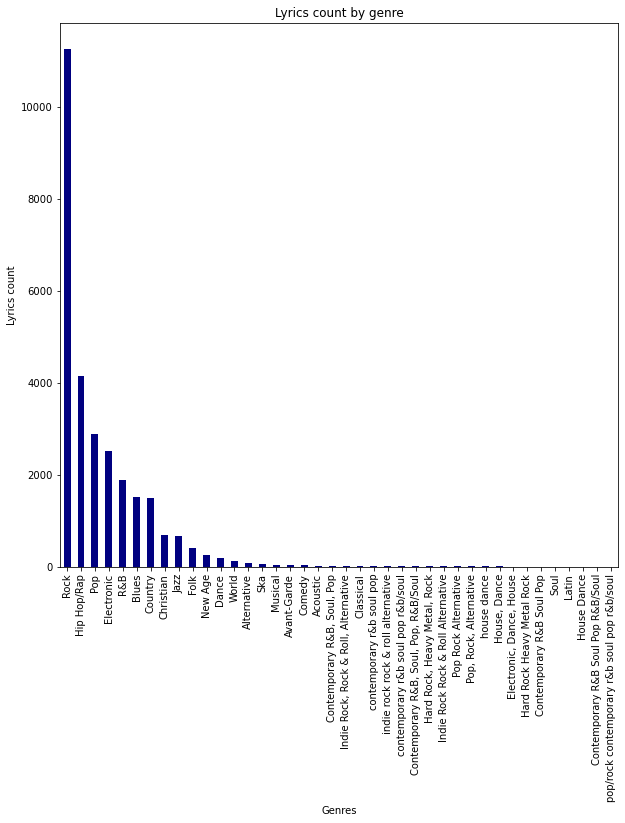

In [16]:
fig = plt.figure(figsize=(10,10))
ax = df_show.groupby('genre').lyrics.count().sort_values(ascending = False).plot.bar(ylim = 0, lw=2, colormap='jet', title='Lyrics count by genre')
ax.set_xlabel("Genres")
ax.set_ylabel("Lyrics count")
plt.show()

### Box plot to show song length by genre

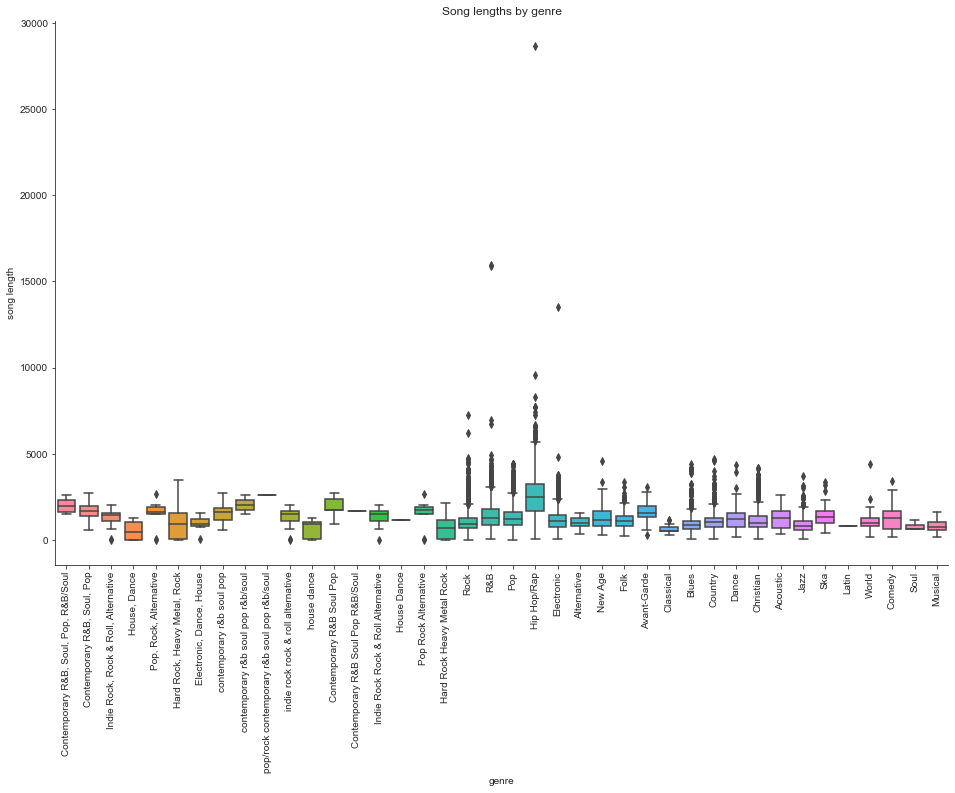

In [17]:
df_len = df_show.copy()
df_len['song length'] = df_len.lyrics.transform(len)

sns.set_style('ticks')
fig, ax = plt.subplots()
ax.set_title('Song lengths by genre')
fig.set_size_inches(16, 10)
plt.setp(ax.get_xticklabels(), rotation=90)
sns.boxplot(ax=ax, data = df_len, x = 'genre', y = 'song length', saturation=1, width=0.8)
sns.despine()

# Debugging section
<hr style="height:2px;border-width:0;color:black;background-color:black">

## Test a single url in site in case of failure

In [ ]:
# url="http://www.songlyrics.com/danger-mouse-jemini-lyrics/"

# request_sleep(3,5)
# response = get_request_response(url, headers)
# if (response is None):
#     print("None")
# else:
#     print("Not None")
# soup_songs = bs(response.content, "html.parser")

## Test a timed out page

In [ ]:
# url="http://www.songlyrics.com/a-pale-horse-named-death-lyrics/"

# request_sleep(3,5)
# response_song = get_request_response(url, headers)

## Test a 404 response page

In [ ]:
# url="http://www.songlyrics.com/l-ame-immortelle/suffocating-endlessly-lyrics/"

# request_sleep(3,5)
# response_song = get_request_response(url, headers)
# if (response_song is None):
#     print("None")
# else:
#     print("Not None")

## _End of crawling notebook_